## Setup and Data Loading

In [10]:
# Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Load data
df = pd.read_csv('pokemon_cleaned.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded: 1025 rows, 43 columns


In [11]:
# Feature selection
base_stats_cols = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']
derived_stats_cols = ['Base Stat Total', 'Physical Offense', 'Physical Defense', 'Special Offense', 'Special Defense Total', 'Offensive Total', 'Defensive Total', 'Stat Variance']
ev_cols = ['Health EV', 'Attack EV', 'Defense EV', 'Special Attack EV', 'Special Defense EV', 'Speed EV', 'EV Yield Total']
physical_cols = ['Pokemon Height', 'Pokemon Weight', 'BMI']
categorical_numeric_cols = ['Catch Rate', 'Base Happiness', 'Male Ratio', 'Female Ratio']
binary_cols = ['Has Secondary Type', 'Has Secondary Ability', 'Has Hidden Ability']

all_numeric_features = base_stats_cols + derived_stats_cols + ev_cols + physical_cols + categorical_numeric_cols + binary_cols

# Remove leakage columns
leak_cols = ['Primary Type Encoded', 'Secondary Type Encoded', 'Primary Type', 'Secondary Type']
features = [col for col in all_numeric_features if col not in leak_cols and col in df.columns]

# Encode target
df['Primary Type Encoded'] = pd.factorize(df['Primary Type'])[0]

# Get top features by correlation
correlations = df[features].corrwith(df['Primary Type Encoded']).abs().sort_values(ascending=False)
top_features = correlations.index.tolist()

print(f"Total features available: {len(top_features)}")
print(f"Unique Pokemon types: {df['Primary Type'].nunique()}")

Total features available: 31
Unique Pokemon types: 18


In [12]:
# Prepare data
X = df[top_features]
y = df['Primary Type Encoded']

# Split data (same split as baseline for comparison)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]} rows")
print(f"Test set: {X_test.shape[0]} rows")
print(f"Features: {len(top_features)}")

Train set: 768 rows
Test set: 257 rows
Features: 31


## Cross-Validation on Baseline Models

In [13]:
# Logistic Regression CV (multi-class)
print("Logistic Regression - 5-Fold Cross-Validation:")
lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
cv_scores_lr = cross_val_score(lr_baseline, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f"  F1 Scores (macro): {cv_scores_lr}")
print(f"  Mean F1: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})\n")

# Random Forest CV
print("Random Forest - 5-Fold Cross-Validation:")
rf_baseline = RandomForestClassifier(random_state=42)
cv_scores_rf = cross_val_score(rf_baseline, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f"  F1 Scores (macro): {cv_scores_rf}")
print(f"  Mean F1: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})\n")

Logistic Regression - 5-Fold Cross-Validation:
  F1 Scores (macro): [0.22160152 0.13587185 0.2263896  0.18884934 0.2120903 ]
  Mean F1: 0.1970 (+/- 0.0332)

Random Forest - 5-Fold Cross-Validation:
  F1 Scores (macro): [0.18240916 0.19888087 0.18765943 0.16012009 0.19960356]
  Mean F1: 0.1857 (+/- 0.0144)



## Hyperparameter Tuning - Logistic Regression

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation F1 score (macro): 0.1970

Test Set Performance:
  Accuracy:  0.2412
  Precision (macro): 0.1784
  Recall (macro):    0.2023
  F1 Score (macro):  0.1865


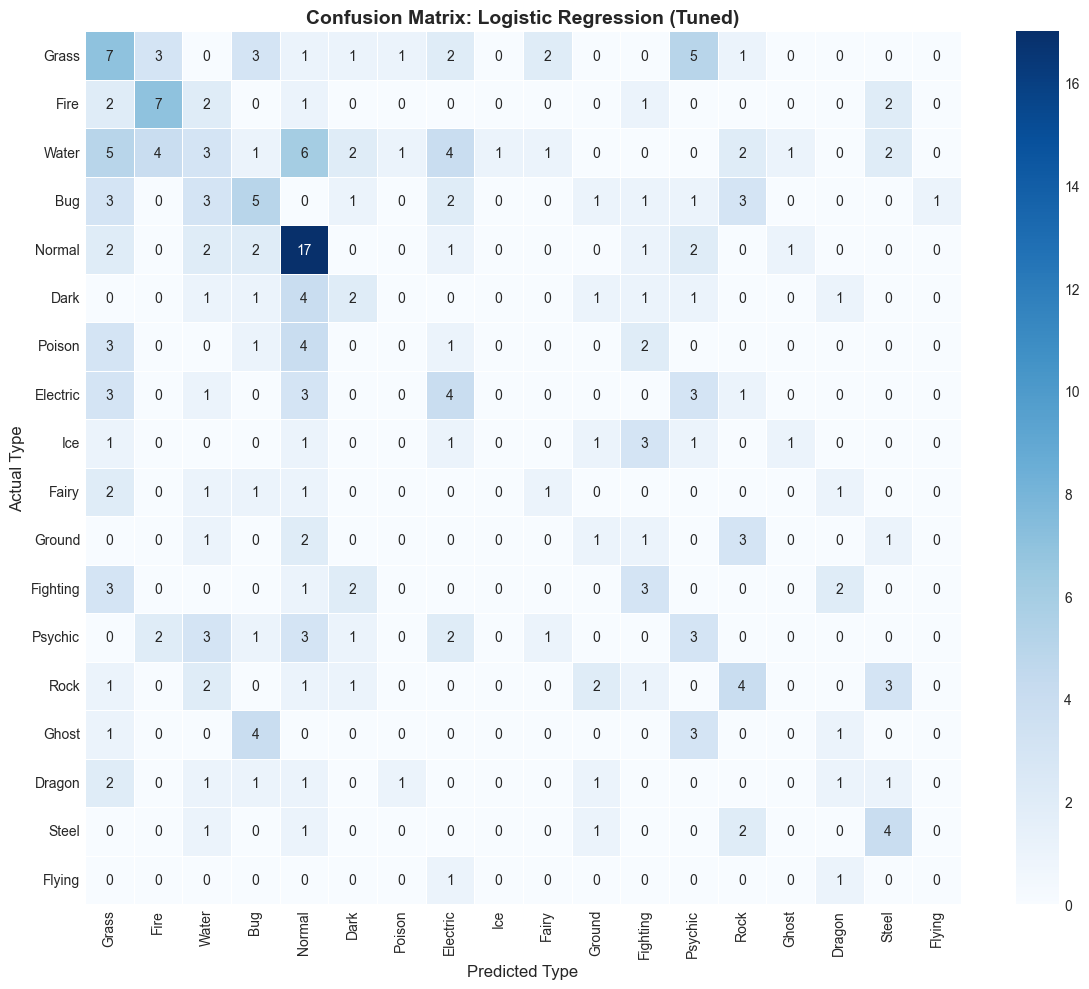

In [14]:
# Define parameter grid for multi-class classification
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
    'class_weight': [None, 'balanced']
}

# Grid search with cross-validation
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=10000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_lr.best_params_}")
print(f"Best cross-validation F1 score (macro): {grid_lr.best_score_:.4f}")

# Evaluate on test set
lr_tuned = grid_lr.best_estimator_
y_pred_lr_tuned = lr_tuned.predict(X_test_scaled)

lr_tuned_acc = accuracy_score(y_test, y_pred_lr_tuned)
lr_tuned_prec = precision_score(y_test, y_pred_lr_tuned, average='macro')
lr_tuned_rec = recall_score(y_test, y_pred_lr_tuned, average='macro')
lr_tuned_f1 = f1_score(y_test, y_pred_lr_tuned, average='macro')
lr_tuned_cm = confusion_matrix(y_test, y_pred_lr_tuned)

print("\nTest Set Performance:")
print(f"  Accuracy:  {lr_tuned_acc:.4f}")
print(f"  Precision (macro): {lr_tuned_prec:.4f}")
print(f"  Recall (macro):    {lr_tuned_rec:.4f}")
print(f"  F1 Score (macro):  {lr_tuned_f1:.4f}")
type_names = [str(t).replace("'", "").replace('"', '') for t in df['Primary Type'].unique()]
cm_df_lr = pd.DataFrame(lr_tuned_cm, columns=type_names, index=type_names)

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df_lr, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5)
plt.title('Confusion Matrix: Logistic Regression (Tuned)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Type', fontsize=12)
plt.ylabel('Actual Type', fontsize=12)
plt.tight_layout()
plt.savefig('figures/models/confusion_matrix_lr_tuned.png', bbox_inches='tight', dpi=300)
plt.show()

## Hyperparameter Tuning - Random Forest

Fitting 5 folds for each of 75 candidates, totalling 375 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best cross-validation F1 score (macro): 0.2136

Test Set Performance:
  Accuracy:  0.2490
  Precision (macro): 0.2086
  Recall (macro):    0.2243
  F1 Score (macro):  0.2105


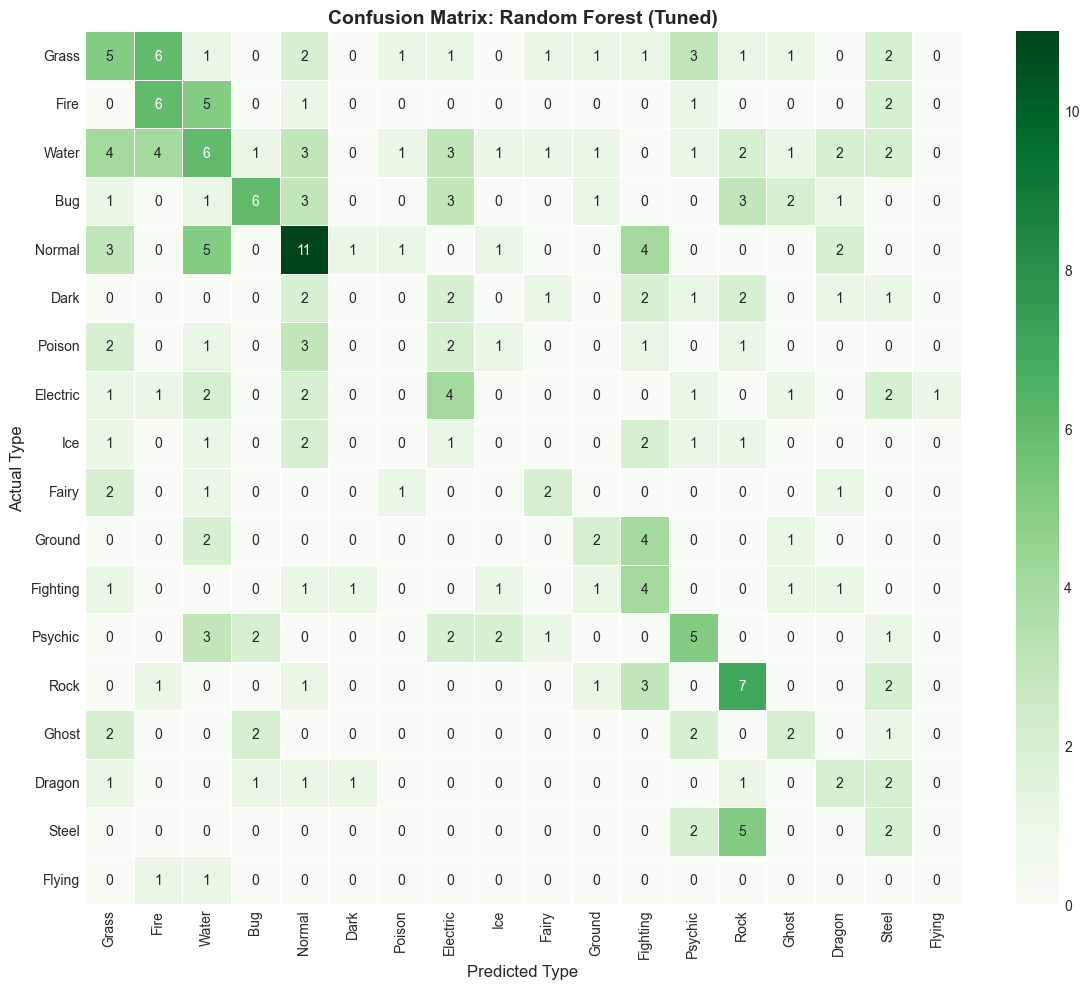

In [15]:
# Define parameter distribution for Random Search
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy']
}

# Randomized search (more efficient for Random Forest)
random_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist_rf,
    n_iter=75,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_rf.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {random_rf.best_params_}")
print(f"Best cross-validation F1 score (macro): {random_rf.best_score_:.4f}")

# Evaluate on test set
rf_tuned = random_rf.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test_scaled)

rf_tuned_acc = accuracy_score(y_test, y_pred_rf_tuned)
rf_tuned_prec = precision_score(y_test, y_pred_rf_tuned, average='macro')
rf_tuned_rec = recall_score(y_test, y_pred_rf_tuned, average='macro')
rf_tuned_f1 = f1_score(y_test, y_pred_rf_tuned, average='macro')
rf_tuned_cm = confusion_matrix(y_test, y_pred_rf_tuned)

print("\nTest Set Performance:")
print(f"  Accuracy:  {rf_tuned_acc:.4f}")
print(f"  Precision (macro): {rf_tuned_prec:.4f}")
print(f"  Recall (macro):    {rf_tuned_rec:.4f}")
print(f"  F1 Score (macro):  {rf_tuned_f1:.4f}")

# Visualize confusion matrix
cm_df_rf = pd.DataFrame(rf_tuned_cm, columns=type_names, index=type_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df_rf, annot=True, fmt='d', cmap='Greens', cbar=True, linewidths=0.5)
plt.title('Confusion Matrix: Random Forest (Tuned)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Type', fontsize=12)
plt.ylabel('Actual Type', fontsize=12)
plt.tight_layout()
plt.savefig('figures/models/confusion_matrix_rf_tuned.png', bbox_inches='tight', dpi=300)
plt.show()

## Model Comparison - Baseline vs Tuned

In [16]:
# Train baseline models for fair comparison
lr_baseline.fit(X_train_scaled, y_train)
rf_baseline.fit(X_train_scaled, y_train)

y_pred_lr_base = lr_baseline.predict(X_test_scaled)
y_pred_rf_base = rf_baseline.predict(X_test_scaled)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': [
        'Logistic Regression (Baseline)',
        'Logistic Regression (Tuned)',
        'Random Forest (Baseline)',
        'Random Forest (Tuned)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_base),
        lr_tuned_acc,
        accuracy_score(y_test, y_pred_rf_base),
        rf_tuned_acc
    ],
    'Precision (Macro)': [
        precision_score(y_test, y_pred_lr_base, average='macro'),
        lr_tuned_prec,
        precision_score(y_test, y_pred_rf_base, average='macro'),
        rf_tuned_prec
    ],
    'Recall (Macro)': [
        recall_score(y_test, y_pred_lr_base, average='macro'),
        lr_tuned_rec,
        recall_score(y_test, y_pred_rf_base, average='macro'),
        rf_tuned_rec
    ],
    'F1 Score (Macro)': [
        f1_score(y_test, y_pred_lr_base, average='macro'),
        lr_tuned_f1,
        f1_score(y_test, y_pred_rf_base, average='macro'),
        rf_tuned_f1
    ]
})

print(comparison_df.to_string(index=False),"\n")

# Identify best model
best_model_idx = comparison_df['F1 Score (Macro)'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1 Score (Macro)']

print(f"Best Model: {best_model_name}")
print(f"Best F1 Score (Macro): {best_f1:.4f}")

                         Model  Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)
Logistic Regression (Baseline)  0.241245           0.178153        0.202322          0.186289
   Logistic Regression (Tuned)  0.241245           0.178445        0.202322          0.186453
      Random Forest (Baseline)  0.276265           0.251479        0.237668          0.233473
         Random Forest (Tuned)  0.249027           0.208550        0.224265          0.210502 

Best Model: Random Forest (Baseline)
Best F1 Score (Macro): 0.2335


## Per-Class Performance Analysis

Classification Report:
              precision    recall  f1-score   support

       Grass       0.25      0.35      0.29        26
        Fire       0.22      0.27      0.24        15
       Water       0.22      0.21      0.22        33
         Bug       0.31      0.24      0.27        21
      Normal       0.36      0.54      0.43        28
        Dark       0.14      0.08      0.11        12
      Poison       0.00      0.00      0.00        11
    Electric       0.24      0.27      0.25        15
         Ice       0.00      0.00      0.00         9
       Fairy       0.50      0.29      0.36         7
      Ground       0.33      0.33      0.33         9
    Fighting       0.27      0.27      0.27        11
     Psychic       0.30      0.44      0.36        16
        Rock       0.29      0.33      0.31        15
       Ghost       0.25      0.22      0.24         9
      Dragon       0.67      0.22      0.33         9
       Steel       0.17      0.22      0.19         9
    

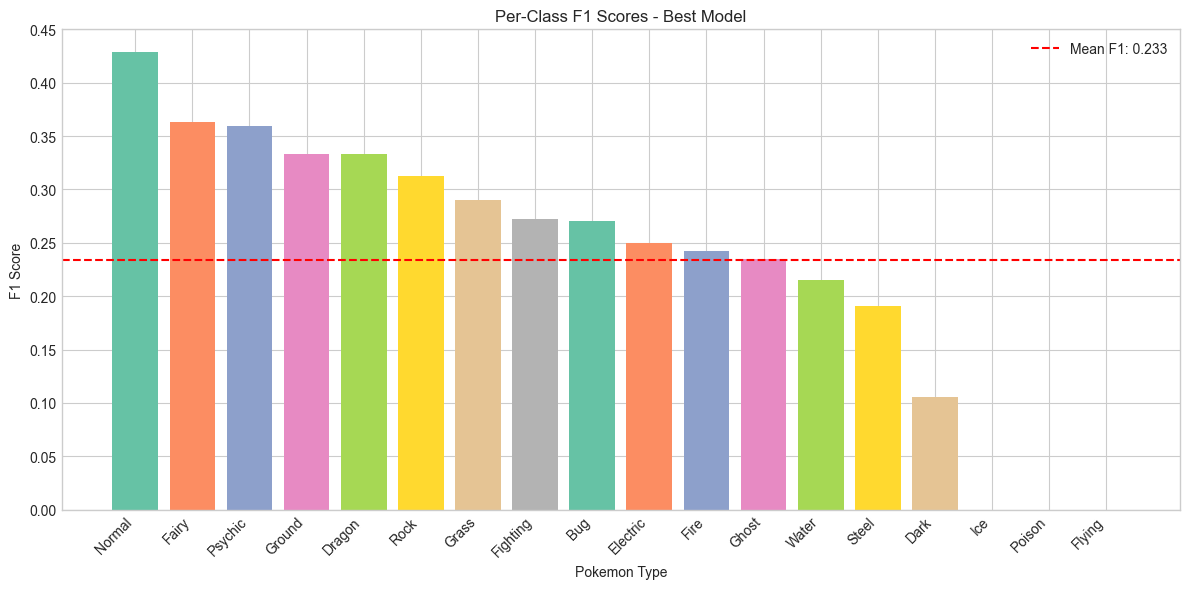

In [17]:
if 'Tuned' in best_model_name:
    if 'Logistic' in best_model_name:
        y_pred_best = y_pred_lr_tuned
    else:
        y_pred_best = y_pred_rf_tuned
else:
    if 'Logistic' in best_model_name:
        y_pred_best = y_pred_lr_base
    else:
        y_pred_best = y_pred_rf_base

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=type_names))

# Per-class F1 scores
per_class_f1 = f1_score(y_test, y_pred_best, average=None)
per_class_df = pd.DataFrame({
    'Type': type_names,
    'F1 Score': per_class_f1
}).sort_values('F1 Score', ascending=False)

print("\nPer-Class F1 Scores (Sorted):")
print(per_class_df.to_string(index=False))

# Visualize per-class performance
plt.figure(figsize=(12, 6))
plt.bar(per_class_df['Type'], per_class_df['F1 Score'], color=sns.color_palette("Set2"))
plt.xlabel('Pokemon Type')
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Scores - Best Model')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=per_class_df['F1 Score'].mean(), color='r', linestyle='--', label=f'Mean F1: {per_class_df["F1 Score"].mean():.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('figures/models/per_class_f1_type.png', bbox_inches='tight', dpi=300)
plt.show()